# Emperical Orthogonal Functions

***This notebook is not finished and completed yet but can be used for inspirational purposes!***

In this notebook, Emperical Orthogonal Functions (EOFs) are calculated and plotted. In the Jasmin handbook pdf, it is explained what EOFs and principal components are.

In [23]:
import os, sys
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
#from mpl_toolkits.basemap import Basemap
import xarray as xr

In [24]:
am_daily = xr.open_dataset('output/am_asia_HADM3.nc')

In [25]:
lat = am_daily['lat'].values
lon = am_daily['lon'].values
am = am_daily['actionmeasure'].values.squeeze()
am.shape

(90360, 54, 40)

In [26]:
X = np.reshape(am, (am.shape[0], len(lat) * len(lon)), order='F')
X.shape

(90360, 2160)

In [27]:
X.shape
landandocean = X

Mask the ocean points

Use skleanr fit and transform methods

In [28]:
# scale and standardise the data
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()
scaler_training_am = scaler.fit(X)

In [29]:
X = scaler_training_am.transform(X)

In [30]:
# verify that mean = 0 and standard deviation 1.
X.mean()

-4.106476388363178e-19

In [31]:
X.std()

1.000000000000001

## EOF decomposition

In [32]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(svd_solver='randomized', whiten=True).fit(X)

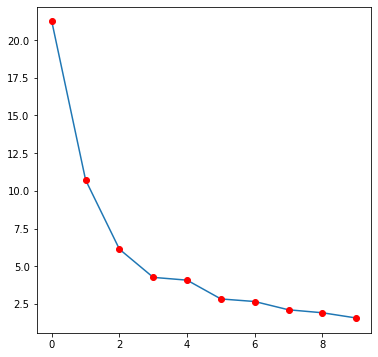

In [33]:
f, ax = plt.subplots(figsize=(6,6))
ax.plot(pca.explained_variance_ratio_[0:10]*100)
ax.plot(pca.explained_variance_ratio_[0:10]*100,'ro')

In [34]:
# calculate number of PCs to explain 70% of variance
ipc = np.where(pca.explained_variance_ratio_.cumsum() >= 0.70)[0][0]
ipc

23

In [35]:
PCs = pca.transform(X)
PCs = PCs[:,:ipc]

In [36]:
## FInd EOFs
EOFs = pca.components_
EOFs = EOFs[:ipc,:]
EOFs.shape

(23, 2160)

In [37]:
lo = ma.masked_array(landandocean)
lo = lo.sum(0).mask
rep = ~lo
## Reconstruct the maps
EOF_recons = np.ones((ipc, len(lat) * len(lon)))* -999

for i in range(ipc): 
    EOF_recons[i,rep] = EOFs[i,:]

EOF_recons = np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F')
EOF_recons.shape   

(23, 40, 54)

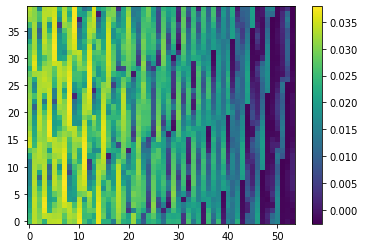

In [38]:
plt.imshow(EOF_recons[0,:,:], origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();

In [ ]:
EOF_recons *= 100

## Plot all 3 EOFs separatety

In [39]:
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

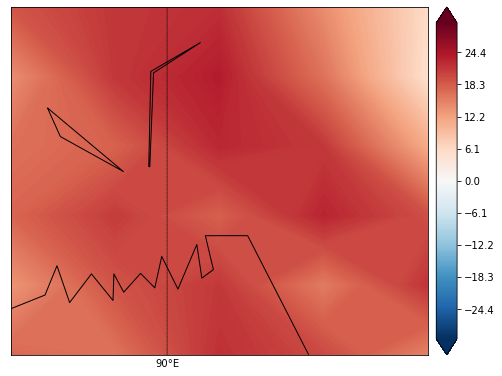

In [52]:
lons, lats = np.meshgrid(lon, lat)
plot_field(m, EOF_recons[0,:,:], lats, lons, -30, 30, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

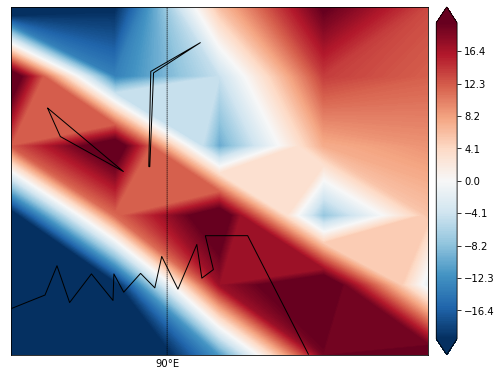

In [49]:
plot_field(m, EOF_recons[1,:,:], lats, lons, -20, 20, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

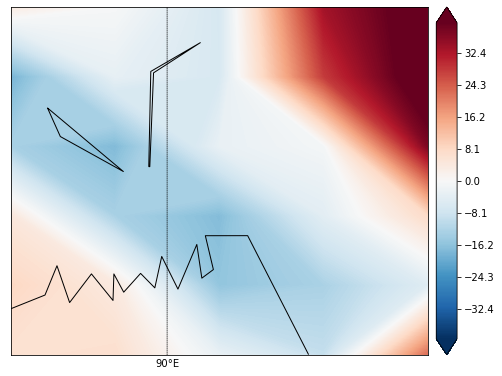

In [55]:
plot_field(m, EOF_recons[2,:,:], lats, lons, -40, 40, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

## Scale the PCs

In [40]:
from sklearn.preprocessing import StandardScaler
scaler_PCs = StandardScaler()
scaler_PCs.fit(PCs)
PCs_std = scaler_PCs.transform(PCs)
PCdf = pd.DataFrame(PCs_std, index = am_daily['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])

In [41]:
PCdf.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9,EOF10,...,EOF14,EOF15,EOF16,EOF17,EOF18,EOF19,EOF20,EOF21,EOF22,EOF23
1850-01-01 12:00:00,-0.381569,-0.150422,-0.28173,0.072738,0.103378,0.085673,0.057043,-0.082647,-0.116879,-0.027983,...,0.056502,-0.061669,0.128808,0.016389,0.034454,0.011147,0.040922,0.087737,-0.045714,-0.110962
1850-01-02 12:00:00,-0.381569,-0.150422,-0.28173,0.072738,0.103378,0.085673,0.057043,-0.082647,-0.116879,-0.027983,...,0.056502,-0.061669,0.128808,0.016389,0.034454,0.011147,0.040922,0.087737,-0.045714,-0.110962
1850-01-03 12:00:00,-0.381569,-0.150422,-0.28173,0.072738,0.103378,0.085673,0.057043,-0.082647,-0.116879,-0.027983,...,0.056502,-0.061669,0.128808,0.016389,0.034454,0.011147,0.040922,0.087737,-0.045714,-0.110962
1850-01-04 12:00:00,-0.381569,-0.150422,-0.28173,0.072738,0.103378,0.085673,0.057043,-0.082647,-0.116879,-0.027983,...,0.056502,-0.061669,0.128808,0.016389,0.034454,0.011147,0.040922,0.087737,-0.045714,-0.110962
1850-01-05 12:00:00,-0.381569,-0.150422,-0.28173,0.072738,0.103378,0.085673,0.057043,-0.082647,-0.116879,-0.027983,...,0.056502,-0.061669,0.128808,0.016389,0.034454,0.011147,0.040922,0.087737,-0.045714,-0.110962


In [42]:
PCdf.to_csv('output_EOFS/am_asia_HADM3_PCAs.csv')

In [43]:
from scipy.signal import detrend

TypeError: float() argument must be a string or a number, not 'cftime._cftime.Datetime360Day'

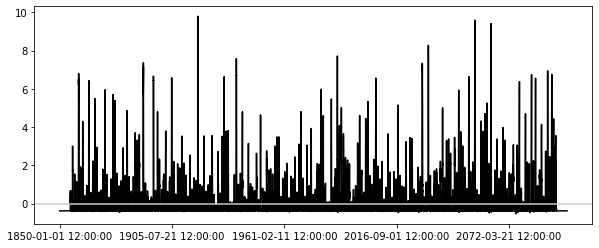

In [44]:
f, ax = plt.subplots(figsize=(10,4))
PCdf.iloc[:,0].plot(ax=ax, color='k', label='PC1')
ax.axhline(0, c='0.8')
#ax.set_xlabel('period', fontsize=18)
ax.plot(PCdf.index, detrend(PCdf.iloc[:,0].values), 'r',  label='PC1 (trend removed)')
ax.grid('off')
ax.legend(loc=1); 